<a href="https://colab.research.google.com/github/kellyslpang/unpackAIworkbooks/blob/main/Kelly_06_multicat_own_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision Multi Category Own Code 

Lesson 6 video from time 0:30:45 to 1:25:05

Own refactored code and notes for Chapter 6: *Multicat with Assignments* (['06_multicat.ipynb'](https://colab.research.google.com/github/vtecftwy/fastbook/blob/master/06_multicat.ipynb))

Refactor the code for the Image Classifier "PASCAL_2007" 

Rewrite the code for the image classifier that identifies multiple objects in an image using PASCAL_2007; or, use your own data set that is properly labelled and has a big enough sample size.
- Only use the code necessary to load the data, create tbe DataLoaders, presize and or augment the images and then train the model using all the knowledge and tools you have learned from the book so far adding the new nowledge you have gained in this chapter.
- In this chapter we are focussing on multi lables, make sure that you show how you have set up your data and the results in your work
- Feel free to add any code that you perfer to use and make a note in the code as to why you perferred to use that code
- Add your own comments that can be used for reference in the future.

###Imports and Setup

In [2]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 31.4MB/s 
     |████████████████████████████████| 194kB 56.8MB/s 
     |████████████████████████████████| 51kB 9.4MB/s 
     |████████████████████████████████| 1.2MB 44.4MB/s 
     |████████████████████████████████| 61kB 9.5MB/s 
     |████████████████████████████████| 61kB 10.1MB/s 
Mounted at /content/gdrive


In [3]:
from fastbook import *

# MULTI LABEL MODEL

###Preparing the data

In [69]:
path = untar_data(URLs.PASCAL_2007)

In [70]:
path.ls()

(#8) [Path('/root/.fastai/data/pascal_2007/segmentation'),Path('/root/.fastai/data/pascal_2007/test.csv'),Path('/root/.fastai/data/pascal_2007/valid.json'),Path('/root/.fastai/data/pascal_2007/train'),Path('/root/.fastai/data/pascal_2007/test.json'),Path('/root/.fastai/data/pascal_2007/train.json'),Path('/root/.fastai/data/pascal_2007/train.csv'),Path('/root/.fastai/data/pascal_2007/test')]

In [71]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [7]:
df.iloc[:,0]

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

In [8]:
df.iloc[0,:]

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

In [9]:
tmp_df = pd.DataFrame({'a':[1,2], 'b':[3,4]})
tmp_df

,a,b
0,1,3
1,2,4


In [10]:
tmp_df['c'] = tmp_df['a']+tmp_df['b']
tmp_df

,a,b,c
0,1,3,4
1,2,4,6


###Assemble the data

In [11]:
dblock = DataBlock()

In [12]:
dsets = dblock.datasets(df)

In [13]:
len(dsets.train),len(dsets.valid)

(4009, 1002)

In [14]:
x,y = dsets.train[0]
x,y

(fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object, fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object)

In [15]:
x['fname']

'008663.jpg'

In [16]:
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('005620.jpg', 'aeroplane')

In [17]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/root/.fastai/data/pascal_2007/train/002549.jpg'), ['tvmonitor'])

In [18]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x325,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]))

In [19]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
dsets.train.vocab[idxs]

(#1) ['train']

In [20]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [21]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)

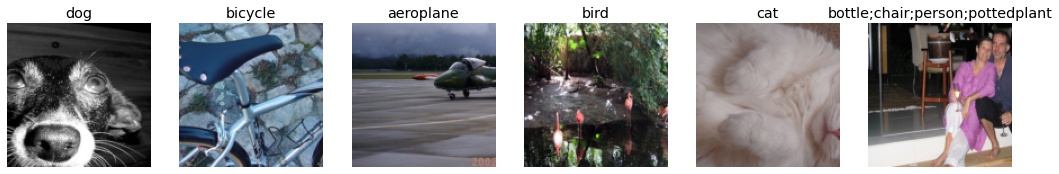

In [22]:
dls.show_batch(nrows=1, ncols=6)

###Train the model

In [23]:
learn = cnn_learner(dls, resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [24]:
x, y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

In [25]:
activs[0]

tensor([ 0.4153,  1.2974, -2.9310,  1.3063, -0.6814, -1.7772,  0.8123, -0.4988, -1.6027,  1.3562,  1.2609,  0.0103,  2.3019, -0.4606, -0.4662,  0.6359, -3.2023, -0.8144, -3.8843, -0.8441],
       grad_fn=<SelectBackward>)

In [26]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, 1-inputs, inputs).log().mean()

In [27]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

TensorMultiCategory(1.0954, grad_fn=<AliasBackward>)

In [28]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.933915,0.709146,0.233048,00:28
1,0.814544,0.558487,0.283167,00:27
2,0.595239,0.208827,0.795418,00:28
3,0.357254,0.122896,0.941056,00:28


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.131862,0.118652,0.937530,00:29
1,0.116097,0.109368,0.955080,00:29
2,0.096182,0.104095,0.950956,00:29


###Evaluate the results and test the model

In [ ]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

In [ ]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

In [29]:
preds,targs = learn.get_preds()

In [ ]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

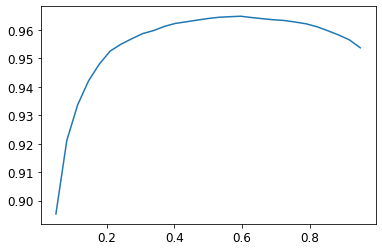

In [30]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

#REGRESSION MODEL

###Preparing the data

In [31]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [32]:
Path.BASE_PATH = path

In [33]:
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

In [34]:
(path/'01').ls().sorted()

(#1000) [Path('01/depth.cal'),Path('01/frame_00003_pose.txt'),Path('01/frame_00003_rgb.jpg'),Path('01/frame_00004_pose.txt'),Path('01/frame_00004_rgb.jpg'),Path('01/frame_00005_pose.txt'),Path('01/frame_00005_rgb.jpg'),Path('01/frame_00006_pose.txt'),Path('01/frame_00006_rgb.jpg'),Path('01/frame_00007_pose.txt')...]

In [35]:
img_files = get_image_files(path)

def img2pose(x): 
    return Path(f'{str(x)[:-7]}pose.txt')

img2pose(img_files[0])

Path('18/frame_00473_pose.txt')

In [36]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

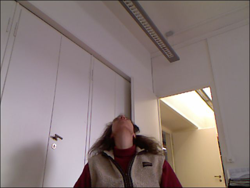

In [37]:
im.to_thumb(250)

In [38]:
# Show the content of one pose text file
with open(img2pose(img_files[0]), 'r') as f:
    txt = f.read()
    print(f"Content of {img2pose(img_files[0]).name}\n{'-'*30}")
    print(txt)

Content of frame_00473_pose.txt
------------------------------
0.998493 -0.0548421 -0.0022367 
0.0176242 0.281753 0.959325 
-0.0519812 -0.957918 0.282295 

27.5469 149.02 1275.61 




In [39]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)

# see documentation fpr genfromtxt here: https://numpy.org/doc/stable/reference/generated/numpy.genfromtxt.html

def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [40]:
get_ctr(img_files[0])

tensor([331.1793, 300.9766])

###Assembling the data

In [41]:
biwi = DataBlock(blocks=(ImageBlock, PointBlock),
                 get_items=get_image_files,
                 get_y=get_ctr,
                 splitter=FuncSplitter(lambda o: o.parent.name=='13'),
                 batch_tfms=[*aug_transforms(size=(240,320)), 
                 Normalize.from_stats(*imagenet_stats)]
                 )

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


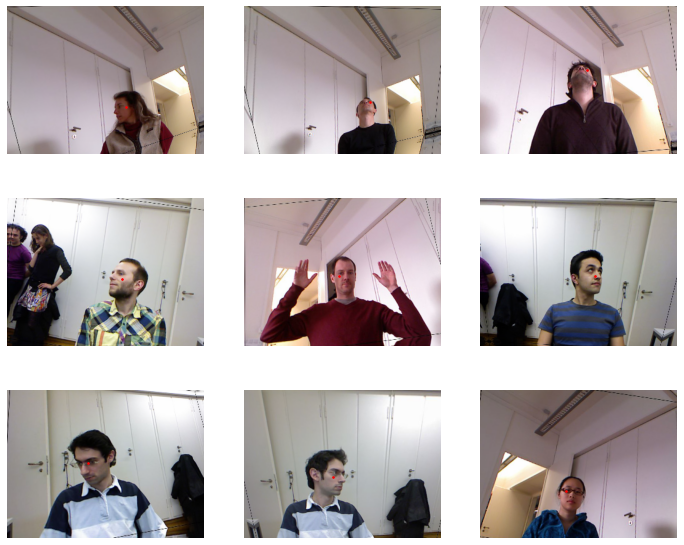

In [42]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(12,10))

In [43]:
xb,yb = dls.one_batch()
xb.shape,yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [44]:
yb[0]

TensorPoint([[-0.0698, -0.0471]], device='cuda:0')

###Training the model


In [45]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

In [47]:
def sigmoid_range(x, lo, hi): 
    return torch.sigmoid(x) * (hi-lo) + lo

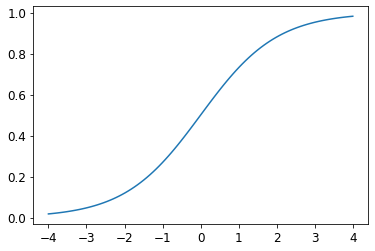

In [58]:
plot_function(torch.sigmoid, min=-4, max=4);

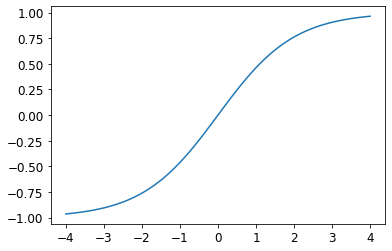

In [48]:
plot_function(partial(sigmoid_range,lo=-1,hi=1), min=-4, max=4);

In [49]:
dls.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(valley=tensor(0.0006))

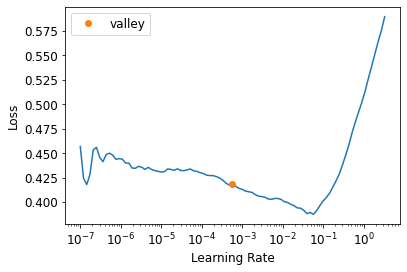

In [59]:
learn.lr_find()

In [60]:
lr = 1e-2
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.045599,0.029951,01:59


epoch,train_loss,valid_loss,time
0,0.008060,0.002214,02:10
1,0.003014,0.000191,02:11
2,0.001387,0.000091,02:09


###Evaluate the results and test the model

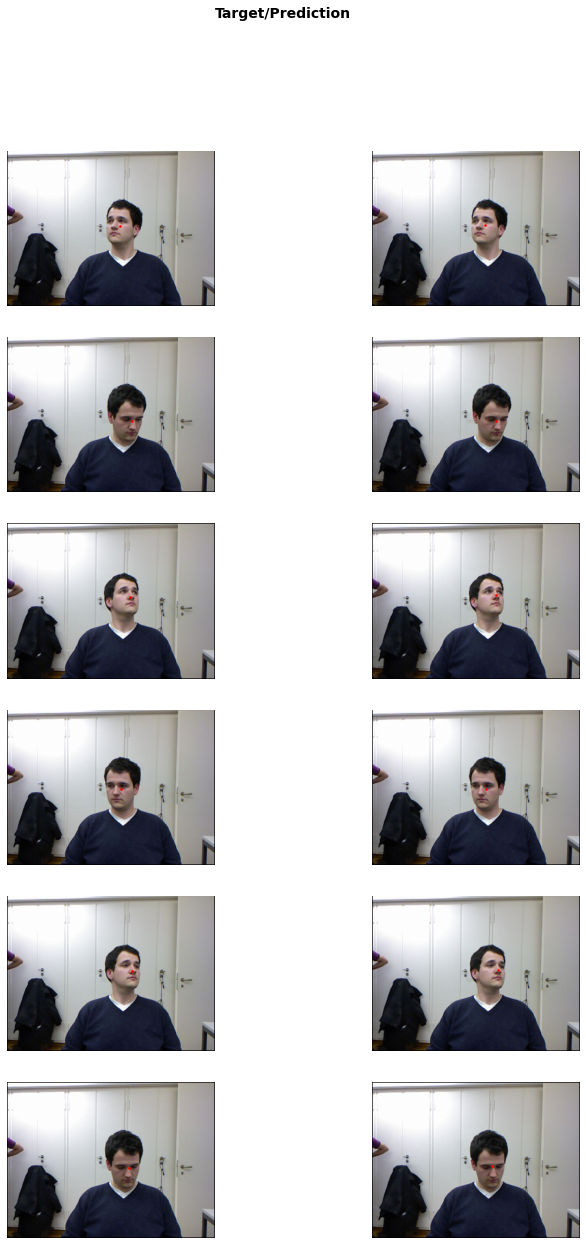

In [61]:
learn.show_results(ds_idx=1, nrows=6, figsize=(12,20))

## Assignment 1: DataLoaders and DataBlocks

In [72]:
# Enter your code for the DataBlock and related custom functions. You can use several cells if more convenient

def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

    



In [77]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))


In [78]:
# Enter the code to test you DabaBlock with summary
dblock.summary(df)

Setting-up type transforms pipelines
0     000005.jpg           chair      True
1     000007.jpg             car      True
2     000009.jpg    horse person      True
3     000012.jpg             car     False
4     000016.jpg         bicycle      True
...          ...             ...       ...
5006  009954.jpg    horse person      True
5007  009955.jpg            boat      True
5008  009958.jpg  person bicycle      True
5009  009959.jpg             car     False
5010  009961.jpg             dog     False

[5011 rows x 3 columns]
Found 5011 items
2 datasets of sizes 2501,2510
Setting up Pipeline: get_x -> PILBase.create
Setting up Pipeline: get_y -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} -> OneHotEncode -- {'c': None}

Building one sample
  Pipeline: get_x -> PILBase.create
    starting from
      fname       000012.jpg
labels             car
is_valid         False
Name: 3, dtype: object
    applying get_x gives
      /root/.fastai/data/pascal_2007/train/00001

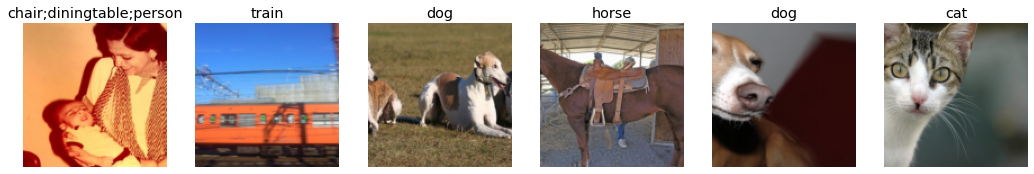

In [79]:
# Enter you code to create the dls, create the model and run a few epochs
dls = dblock.dataloaders(df)
dls.show_batch(nrows=1, ncols=6)


In [80]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

TensorMultiCategory(1.0954, grad_fn=<AliasBackward>)

In [81]:
learn = cnn_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.990333,0.743155,0.183287,00:26
1,0.864754,0.591344,0.212769,00:26
2,0.637122,0.218348,0.798486,00:26
3,0.388437,0.143489,0.929801,00:26


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.156234,0.126968,0.939323,00:26
1,0.136788,0.121271,0.942948,00:26
2,0.118560,0.118666,0.940478,00:26


Find best threshold level:

In [82]:
preds,targs = learn.get_preds()

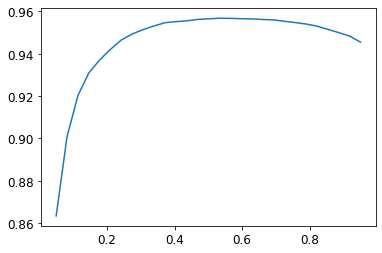

In [83]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);

## Assignment 2: Discover a new dataset

1. Explore the files to identify what information can be gathered (README file, meta data, ...?)
2. Decide what the right approach is for the dataset
3. Create the DataLoaders and test it.

In [84]:
# Load the dataset
path = untar_data(URLs.BIWI_HEAD_POSE)
Path.BASE_PATH = path
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

Create lists using pathlib.Path:

In [85]:
print('Files:')
print(' ', [p.name for p in path.ls().sorted() if p.is_file()])
print('Text Files:')
print(' ', [p.name for p in path.ls() if p.suffix == '.txt'])
print('Obj Files')
print(' ', [p.name for p in path.ls() if p.suffix == '.obj'])
print('Folders')
print(' ', [p.name for p in path.ls().sorted() if p.is_dir()])

Files:
  ['01.obj', '02.obj', '03.obj', '04.obj', '05.obj', '06.obj', '07.obj', '08.obj', '09.obj', '10.obj', '11.obj', '12.obj', '13.obj', '14.obj', '15.obj', '16.obj', '17.obj', '18.obj', '19.obj', '20.obj', '21.obj', '22.obj', '23.obj', '24.obj', 'io_sample.cpp', 'readme.txt']
Text Files:
  ['readme.txt']
Obj Files
  ['03.obj', '09.obj', '13.obj', '11.obj', '14.obj', '20.obj', '05.obj', '15.obj', '23.obj', '16.obj', '04.obj', '12.obj', '17.obj', '21.obj', '18.obj', '24.obj', '01.obj', '08.obj', '07.obj', '02.obj', '06.obj', '19.obj', '10.obj', '22.obj']
Folders
  ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24']


In [86]:
with open(path/'readme.txt', 'r') as f:
    txt = f.read()

print(txt)

Biwi Kinect Head Pose Database

This database is made available for non-commercial use such as university research and education.

We kindly ask you to cite the following reference in your publications related to this work:

@article{fanelli_IJCV,
  author = {Fanelli, Gabriele and Dantone, Matthias and Gall, Juergen and Fossati, Andrea and Van Gool, Luc},
  title = {Random Forests for Real Time 3D Face Analysis},
  journal = {Int. J. Comput. Vision},
  year = {2013},
  month = {February},
  volume = {101},
  number = {3},
  pages = {437--458}
}

The database contains 24 sequences acquired with a Kinect sensor. 20 people (some were recorded twice - 6 women and 14 men) were recorded while turning their heads, sitting in front of the sensor, at roughly one meter of distance.

For each sequence, the corresponding .obj file represents a head template deformed to match the neutral face of that specific person.
In each folder, two .cal files contain calibration information for the depth and t

In [87]:
folder = path / '01'
list_of_paths = folder.ls().sorted()

print('Files:')
print(' ', [p.name for p in list_of_paths if p.is_file()])
print('Text Files:')
print(' ', [p.name for p in list_of_paths if p.suffix == '.txt'])
print('image files')
print(' ', [p.name for p in list_of_paths if p.suffix == '.jpg'])
print('Calibration Files')
print(' ', [p.name for p in list_of_paths if p.suffix == '.cal'])
print('Other files')
print(' ', [p.name for p in list_of_paths if p.is_file() and p.suffix not in ['.txt', '.cal', '.jpg']])
print('Set of file for one frame')
print(' ', [p.name for p in list_of_paths if p.is_file() and '_00003_' in p.name])

Files:
  ['depth.cal', 'frame_00003_pose.txt', 'frame_00003_rgb.jpg', 'frame_00004_pose.txt', 'frame_00004_rgb.jpg', 'frame_00005_pose.txt', 'frame_00005_rgb.jpg', 'frame_00006_pose.txt', 'frame_00006_rgb.jpg', 'frame_00007_pose.txt', 'frame_00007_rgb.jpg', 'frame_00008_pose.txt', 'frame_00008_rgb.jpg', 'frame_00009_pose.txt', 'frame_00009_rgb.jpg', 'frame_00010_pose.txt', 'frame_00010_rgb.jpg', 'frame_00011_pose.txt', 'frame_00011_rgb.jpg', 'frame_00012_pose.txt', 'frame_00012_rgb.jpg', 'frame_00013_pose.txt', 'frame_00013_rgb.jpg', 'frame_00014_pose.txt', 'frame_00014_rgb.jpg', 'frame_00015_pose.txt', 'frame_00015_rgb.jpg', 'frame_00016_pose.txt', 'frame_00016_rgb.jpg', 'frame_00017_pose.txt', 'frame_00017_rgb.jpg', 'frame_00018_pose.txt', 'frame_00018_rgb.jpg', 'frame_00019_pose.txt', 'frame_00019_rgb.jpg', 'frame_00020_pose.txt', 'frame_00020_rgb.jpg', 'frame_00021_pose.txt', 'frame_00021_rgb.jpg', 'frame_00022_pose.txt', 'frame_00022_rgb.jpg', 'frame_00023_pose.txt', 'frame_00023_

In [88]:
with open(path/'01/rgb.cal', 'r') as f:
    txt = f.read()
print(txt)

517.679 0 320 
0 517.679 240.5 
0 0 1 

0 0 0 0 

0.999947 0.00432361 0.00929419 
-0.00446314 0.999877 0.0150443 
-0.009228 -0.015085 0.999844 

-24.0198 5.8896 -13.2308 

640 480



In [89]:
with open(path/'01/frame_00003_pose.txt', 'r') as f:
    txt = f.read()
print(txt)

0.997978 0.0272944 0.0574071 
-0.0346956 0.990621 0.132163 
-0.0532613 -0.133887 0.989564 

51.9358 38.2631 881.756 




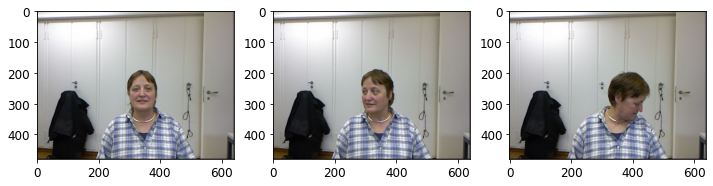

In [90]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))

img = Image.open(path / '01/frame_00003_rgb.jpg')
axs[0].imshow(img)
img = Image.open(path / '01/frame_00250_rgb.jpg')
axs[1].imshow(img)
img = Image.open(path / '01/frame_00501_rgb.jpg')
axs[2].imshow(img)

plt.show()

## Assignment 3: Frame a new regression problem

Each of the 24 folders consist of a sequence of images of a person turning its head. Can we predict where the head will be, say, next frames after seeing 5 frames?



1.   Use data from URLs.BIWI_HEAD_POSE
2.   Pick a random person from the data
3.   Pick a random image from that person's sequence
4.   Get the head position data for that image + 4 images 
5.   Use a regression model to fit the 5 data points
6.   Using the fitted regression model, predict where the next data point will lie. We are assuming the shots were taken between a fixed time interval.
7.   Take next image from the sequence and compare with our prediction






## Questionnaire

1. **How could multi-label classification improve the usability of the bear classifier?**
Improve the model to take into account photos with more than one type of bear and photos with no bears
1. **How do we encode the dependent variable in a multi-label classification problem?**
one-hot encoding
1. How do you access the rows and columns of a DataFrame as if it was a matrix? (Pandas question)
1. How do you get a column by name from a DataFrame? (Pandas question)
1. **What is the difference between a `Dataset` and `DataLoader`?**
Dataset:: A collection that returns a tuple of your independent and dependent variable for a single item
DataLoader:: An iterator that provides a stream of mini-batches, where each mini-batch is a tuple of a batch of independent variables and a batch of dependent variables
1. **What does a `Datasets` object normally contain?**
Datasets:: An object that contains a training Dataset and a validation Dataset

1. **What does a `DataLoaders` object normally contain?**
DataLoaders:: An object that contains a training DataLoader and a validation DataLoader
1. What does `lambda` do in Python?
1. **What are the methods to customize how the independent and dependent variables are created with the data block API?**
get_x and get_y
1. **Why is softmax not an appropriate output activation function when using a one hot encoded target?**
however, we may well have multiple objects that we're confident appear in an image, so restricting the maximum sum of activations to 1 is not a good idea. By the same reasoning, we may want the sum to be less than 1, if we don't think any of the categories appear in an image.
1. **Why is `nll_loss` not an appropriate loss function when using a one-hot-encoded target?**
nll_loss is for single-label datasets (like MNIST or the Pet dataset), where the target is encoded as a single integer,
1. **What is the difference between `nn.BCELoss` and `nn.BCEWithLogitsLoss`?**
no Sigmoid vs sigmoid
1. **Why can't we use regular accuracy in a multi-label problem?**
doesn't work because we could have more than one prediction on a single image.
1. **When is it okay to tune a hyperparameter on the validation set?**
n this case, we're using the validation set to pick a hyperparameter (the threshold), which is the purpose of the validation set. Sometimes students have expressed their concern that we might be overfitting to the validation set, since we're trying lots of values to see which is the best. However, as you see in the plot, changing the threshold in this case results in a smooth curve, so we're clearly not picking some inappropriate outlier. This is a good example of where you have to be careful of the difference between theory (don't try lots of hyperparameter values or you might overfit the validation set) versus practice (if the relationship is smooth, then it's fine to do this).

1. How is `y_range` implemented in fastai? (See if you can implement it yourself and test it without peeking!)
1. **What is a regression problem? What loss function should you use for such a problem?**
A model is defined by its independent and dependent variables, along with its loss function. 

Image regression is just another CNN on top of the data block API.

FlattenedLoss of MSELoss()

1. **What do you need to do to make sure the fastai library applies the same data augmentation to your input images and your target point coordinates?**
PointBlock
